In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from collections import defaultdict
from tqdm import tqdm

from model import ReachabilityModel
from play_class import play

#### Create Array of Pandas Dataframes for each CSV File in Dataset

In [3]:
dfs = []
datapath = os.getcwd() + '\data'
for item in os.listdir(datapath):
    fullpath = os.path.join(datapath, item)
    if os.path.isfile(fullpath):
        dfs.append(pd.read_csv('data/' + item))

C:\Users\cwphu\AppData\Local\Temp\ipykernel_28612\3426312423.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv('data/' + item))


#### Clean Each Input/Output DF

In [4]:
def cleanInputData(df):
    cleandf = df.copy()
    # remove all plays where num frames >= 50 due to dataset tracking error
    cleandf = cleandf[cleandf['num_frames_output'] < 50]
    # generate unique play id by concatenating game id (game), play id (play)
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    # generate x/y components of velocity, acceleration
    cleandf['v_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['v_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['a_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['a_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['o'] = cleandf['o']/360.0
    cleandf = cleandf.drop(columns=['s', 'a', 'dir'])
    return cleandf

def cleanOutputData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    return cleandf

def cleanSupplementaryData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    return cleandf

In [5]:
clean_input_dfs = []
for i in range(0, 18):
    clean_input_dfs.append(cleanInputData(dfs[i]))
clean_output_dfs = []
for i in range(18, 36):
    clean_output_dfs.append(cleanOutputData(dfs[i]))

clean_sup_df = cleanSupplementaryData(dfs[36])

In [6]:
clean_input_dfs[0]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y,o,num_frames_output,ball_land_x,ball_land_y,unique_play_id,v_x,v_y,a_x,a_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,36.94,0.661778,21,63.259998,-0.22,2023090700101,-0.054913,0.071306,-0.237957,0.308993
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,36.94,0.655694,21,63.259998,-0.22,2023090700101,-0.014263,-0.037371,-0.217511,-0.569903
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,36.93,0.668333,21,63.259998,-0.22,2023090700101,0.064388,-0.101263,0.391691,-0.616018
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,36.92,0.678472,21,63.259998,-0.22,2023090700101,0.172526,-0.152102,0.607590,-0.535663
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,36.90,0.678472,21,63.259998,-0.22,2023090700101,0.292667,-0.191954,0.685676,-0.449720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285709,2023091100,3987,True,42489,29,left,87,Stefon Diggs,6-0,191,...,14.72,0.936528,11,73.870003,11.48,20230911003987,-3.941286,1.768804,-5.391898,2.419822
285710,2023091100,3987,True,42489,30,left,87,Stefon Diggs,6-0,191,...,14.88,0.013583,11,73.870003,11.48,20230911003987,-3.066950,1.623181,-5.895261,3.120063
285711,2023091100,3987,True,42489,31,left,87,Stefon Diggs,6-0,191,...,15.03,0.105167,11,73.870003,11.48,20230911003987,-2.303738,1.464818,-5.780441,3.675459
285712,2023091100,3987,True,42489,32,left,87,Stefon Diggs,6-0,191,...,15.16,0.144278,11,73.870003,11.48,20230911003987,-1.516783,1.209532,-5.355652,4.270772


#### Generate Player ID -> Name Dictionary

In [7]:
player_dict = dict()
for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        id = row['nfl_id']
        max_play_len = max(max_play_len, row['frame_id'])
        if id not in player_dict:
            name = row['player_name']
            player_dict[id] = name

In [8]:
player_dict

{54527: 'Bryan Cook',
 46137: 'Justin Reid',
 52546: "L'Jarius Sneed",
 53487: 'Nick Bolton',
 54486: 'Trent McDuffie',
 53541: 'Amon-Ra St. Brown',
 53959: 'Brock Wright',
 43290: 'Jared Goff',
 44930: 'Josh Reynolds',
 44888: 'Alex Anzalone',
 55910: 'Brian Branch',
 47888: 'C.J. Gardner-Johnson',
 44906: 'Cameron Sutton',
 53953: 'Jerry Jacobs',
 54562: 'Kerby Joseph',
 54653: 'Malcolm Rodriguez',
 46213: 'Justin Watson',
 46243: 'Marquez Valdes-Scantling',
 53591: 'Noah Gray',
 54519: 'Skyy Moore',
 44822: 'Patrick Mahomes',
 41325: 'Jerick McKinnon',
 53542: 'Derrick Barnes',
 52440: 'Clyde Edwards-Helaire',
 46309: 'Richie James',
 54495: 'George Karlaftis',
 47882: 'Mike Edwards',
 43584: 'Kalif Raymond',
 55899: 'Sam LaPorta',
 38696: 'Marvin Jones',
 54600: 'Joshua Williams',
 55984: 'Chamarri Conner',
 52471: 'Willie Gay Jr.',
 47856: 'David Montgomery',
 55876: 'Jahmyr Gibbs',
 54568: 'Leo Chenal',
 46424: 'Jason Cabinda',
 55882: 'Jack Campbell',
 54716: 'Isiah Pacheco',
 5

#### Generate Play Id -> Coverage Dictionary

In [9]:
coverage_dict = dict()
for _,row in clean_sup_df.iterrows():
    id = row['unique_play_id']
    coverage_dict[id] = row['team_coverage_man_zone']

In [10]:
coverage_dict

{'20230907003461': 'ZONE_COVERAGE',
 '2023090700461': 'ZONE_COVERAGE',
 '20230907001940': 'ZONE_COVERAGE',
 '20230907001711': 'ZONE_COVERAGE',
 '20230907001588': 'ZONE_COVERAGE',
 '2023090700101': 'ZONE_COVERAGE',
 '20230907003566': 'MAN_COVERAGE',
 '2023090700902': 'MAN_COVERAGE',
 '20230907001069': 'ZONE_COVERAGE',
 '20230907002261': 'MAN_COVERAGE',
 '20230907002435': 'ZONE_COVERAGE',
 '20230907002906': 'ZONE_COVERAGE',
 '2023090700713': 'ZONE_COVERAGE',
 '20230907001741': 'MAN_COVERAGE',
 '20230907003971': 'ZONE_COVERAGE',
 '20230907003032': 'MAN_COVERAGE',
 '2023090700361': 'ZONE_COVERAGE',
 '20230907002638': 'MAN_COVERAGE',
 '2023090700736': 'MAN_COVERAGE',
 '20230907001154': 'ZONE_COVERAGE',
 '20230907001812': 'ZONE_COVERAGE',
 '20230907003089': 'ZONE_COVERAGE',
 '20230907001618': 'ZONE_COVERAGE',
 '20230907002306': 'ZONE_COVERAGE',
 '20230907002141': 'ZONE_COVERAGE',
 '20230907003324': 'MAN_COVERAGE',
 '20230907001001': 'MAN_COVERAGE',
 '20230907004041': 'ZONE_COVERAGE',
 '20230

#### Process Input Datasets

In [11]:
full_data = dict()

for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        play_id = row['unique_play_id']

        # filter to only include zone coverage plays
        if coverage_dict[play_id] == 'ZONE_COVERAGE':
            if play_id not in full_data.keys():
                full_data[play_id] = play()
            this_play = full_data[play_id]

            player_id = row['nfl_id']
            # if is player to predict
            if row['player_to_predict'] == True:
                this_play.target_player_id = player_id
                this_play.target_player_name = row['player_name']
                this_play.target_player_position = row['player_position']
                # log target info
                target_data = np.array([row['num_frames_output'], row['ball_land_x'], row['ball_land_y']])
                this_play.target = target_data

            # add movement to player movement dict
            data = np.array([row['x'], row['y'], row['o'], row['v_x'], row['v_y'], row['a_x'], row['a_y']])
            if player_id not in this_play.player_movement_input:
                this_play.player_movement_input[player_id] = [data]
            else:
                this_play.player_movement_input[player_id].append(data)

#### Process Output Datasets

In [12]:
for clean_dfs in clean_output_dfs:
    for _,row in clean_dfs.iterrows():
        play_id = row['unique_play_id']

        if play_id in full_data.keys():
            player_id = row['nfl_id']
            this_play = full_data[play_id]

            data = np.array([row['x'], row['y']])
            if player_id not in this_play.player_movement_output:
                this_play.player_movement_output[player_id] = [data]
            else:
                this_play.player_movement_output[player_id].append(data)

#### Process Supplementary Dataset

In [13]:
for _,row in clean_sup_df.iterrows():
    play_id = row['unique_play_id']
    
    if play_id in full_data.keys():
        this_play = full_data[play_id]
        this_play.receiver_route = row['route_of_targeted_receiver']
        this_play.defensive_coverage = row['team_coverage_type']
        this_play.offense_team = row['possession_team']
        this_play.defense_team = row['defensive_team']
        this_play.pass_result = row['pass_result']

In [14]:
# Final consistency checks
for key in full_data.keys():
    if full_data[key].target_player_id == None:
        print(key)
        print('missing target player')
    if full_data[key].defensive_coverage == None:
        print(key)
        print('missing coverage')
    if 'MAN' in full_data[key].defensive_coverage:
        print(key)
        print('wrong coverage (man)')

#### Generate Overlays and Scores

In [15]:
for key in tqdm(full_data):
    full_data[key].generate_overlays_and_score()

100%|██████████| 10090/10090 [09:02<00:00, 18.60it/s]


#### Save Results to CSV

In [16]:
processed_data = []
for key, play_obj in full_data.items():
    play_data = {
        'unique_play_id': key,
        'target_player_id': play_obj.target_player_id,
        'target_player_name': play_obj.target_player_name,
        'target_player_position': play_obj.target_player_position,
        'receiver_route': play_obj.receiver_route,
        'defensive_coverage': play_obj.defensive_coverage,
        'offense_team': play_obj.offense_team,
        'defense_team': play_obj.defense_team,
        'pass_result': play_obj.pass_result,
        'score': play_obj.score
    }
    processed_data.append(play_data)
processed_data_df = pd.DataFrame(processed_data)

In [17]:
processed_data_df

,unique_play_id,target_player_id,target_player_name,target_player_position,receiver_route,defensive_coverage,offense_team,defense_team,pass_result,score
0,2023090700101,44930,Josh Reynolds,WR,CORNER,COVER_2_ZONE,DET,KC,I,-417.247742
1,2023090700219,53591,Noah Gray,TE,HITCH,COVER_4_ZONE,KC,DET,C,-19.368916
2,2023090700361,38696,Marvin Jones,WR,HITCH,COVER_4_ZONE,DET,KC,C,-164.443650
3,2023090700461,44930,Josh Reynolds,WR,POST,COVER_6_ZONE,DET,KC,C,-153.160174
4,2023090700530,53541,Amon-Ra St. Brown,WR,OUT,COVER_2_ZONE,DET,KC,C,-21.553753
...,...,...,...,...,...,...,...,...,...,...
10085,20240107133515,43454,Tyreek Hill,WR,POST,COVER_4_ZONE,MIA,BUF,I,-105.976501
10086,20240107133570,54528,James Cook,RB,FLAT,COVER_3_ZONE,BUF,MIA,C,22.906378
10087,20240107133836,54613,Khalil Shakir,WR,SLANT,COVER_4_ZONE,BUF,MIA,C,-21.229598
10088,20240107133906,43454,Tyreek Hill,WR,HITCH,COVER_4_ZONE,MIA,BUF,C,-145.714206


In [18]:
processed_data_df.to_csv('processed_data.csv', index=False)

#### Generate Useful Metrics

In [19]:
player_metrics_df = processed_data_df.groupby('target_player_name', as_index=False).agg(
    position=('target_player_position', 'first'), 
    avg_score=('score', 'mean'),
    median_score=('score', 'median'),
    count=('score', 'count'),
    I_count=('pass_result', lambda x: (x == 'I').sum()),
    C_count=('pass_result', lambda x: (x == 'C').sum())
)
player_metrics_df['I_pct'] = player_metrics_df['I_count'] / player_metrics_df['count']
player_metrics_df['C_pct'] = player_metrics_df['C_count'] / player_metrics_df['count']

player_metrics_df.to_csv('player_metrics.csv', index=False)
player_metrics_df.head()

,target_player_name,position,avg_score,median_score,count,I_count,C_count,I_pct,C_pct
0,A.J. Brown,WR,-289.609443,-83.983355,76,18,57,0.236842,0.750000
1,A.T. Perry,WR,-608.504404,-203.586494,11,3,8,0.272727,0.727273
2,AJ Dillon,RB,4.945572,3.388049,20,4,16,0.200000,0.800000
3,Aaron Jones,RB,-27.337906,2.434554,18,6,12,0.333333,0.666667
4,Adam Prentice,FB,4.740909,4.740909,2,0,2,0.000000,1.000000


In [20]:
team_off_metrics = processed_data_df.groupby('offense_team', as_index=False).agg(
    avg_score=('score', 'mean'),
    median_score=('score', 'median'),
    count=('score', 'count'),
    I_count=('pass_result', lambda x: (x == 'I').sum()),
    C_count=('pass_result', lambda x: (x == 'C').sum())
)
team_off_metrics['I_pct'] = team_off_metrics['I_count'] / team_off_metrics['count']
team_off_metrics['C_pct'] = team_off_metrics['C_count'] / team_off_metrics['count']

team_off_metrics.to_csv('offense_metrics.csv', index=False)
team_off_metrics.head()

,offense_team,avg_score,median_score,count,I_count,C_count,I_pct,C_pct
0,ARI,-153.569562,-27.606351,328,83,236,0.253049,0.719512
1,ATL,-180.633016,-37.266346,325,92,223,0.283077,0.686154
2,BAL,-181.079084,-37.631216,260,71,187,0.273077,0.719231
3,BUF,-123.556190,-27.997809,300,60,229,0.200000,0.763333
4,CAR,-129.273795,-41.756466,306,79,222,0.258170,0.725490


In [21]:
avg_scores = team_off_metrics['avg_score'].to_numpy()
med_scores = team_off_metrics['median_score'].to_numpy()
c_pct = team_off_metrics['C_pct'].to_numpy()

avg_correlation_matrix = np.corrcoef(avg_scores, c_pct)
avg_correlation_coefficient = avg_correlation_matrix[0, 1]
med_correlation_matrix = np.corrcoef(med_scores, c_pct)
med_correlation_coefficient = med_correlation_matrix[0, 1]
print(f"Avg -> C_pct Correlation: {avg_correlation_coefficient}")
print(f"Med -> C_pct Correlation: {med_correlation_coefficient}")

Avg -> C_pct Correlation: 0.34378021090321953
Med -> C_pct Correlation: 0.14133479923672465


In [22]:
team_def_metrics = processed_data_df.groupby('defense_team', as_index=False).agg(
    avg_score=('score', 'mean'),
    median_score=('score', 'median'),
    count=('score', 'count'),
    I_count=('pass_result', lambda x: (x == 'I').sum()),
    C_count=('pass_result', lambda x: (x == 'C').sum())
)
team_def_metrics['I_pct'] = team_def_metrics['I_count'] / team_def_metrics['count']
team_def_metrics['C_pct'] = team_def_metrics['C_count'] / team_def_metrics['count']

team_def_metrics.to_csv('defense_metrics.csv', index=False)
team_def_metrics.head()

,defense_team,avg_score,median_score,count,I_count,C_count,I_pct,C_pct
0,ARI,-159.562669,-38.527881,307,68,235,0.221498,0.765472
1,ATL,-197.070953,-38.646974,252,68,179,0.269841,0.710317
2,BAL,-158.331869,-42.553344,341,91,238,0.266862,0.697947
3,BUF,-131.369856,-30.448851,328,73,242,0.222561,0.737805
4,CAR,-171.537250,-36.142836,293,78,210,0.266212,0.716724


In [23]:
avg_scores = team_def_metrics['avg_score'].to_numpy()
med_scores = team_def_metrics['median_score'].to_numpy()
c_pct = team_def_metrics['C_pct'].to_numpy()

avg_correlation_matrix = np.corrcoef(avg_scores, c_pct)
avg_correlation_coefficient = avg_correlation_matrix[0, 1]
med_correlation_matrix = np.corrcoef(med_scores, c_pct)
med_correlation_coefficient = med_correlation_matrix[0, 1]
print(f"Avg -> C_pct Correlation: {avg_correlation_coefficient}")
print(f"Med -> C_pct Correlation: {med_correlation_coefficient}")

Avg -> C_pct Correlation: -0.08410984383465632
Med -> C_pct Correlation: 0.11321289050400977


#### Score Metrics

In [24]:
labels = processed_data_df['pass_result'].to_numpy()
scores = processed_data_df['score'].to_numpy()

Average Score: -98.7478576998441
Median Score: -25.653277095348006


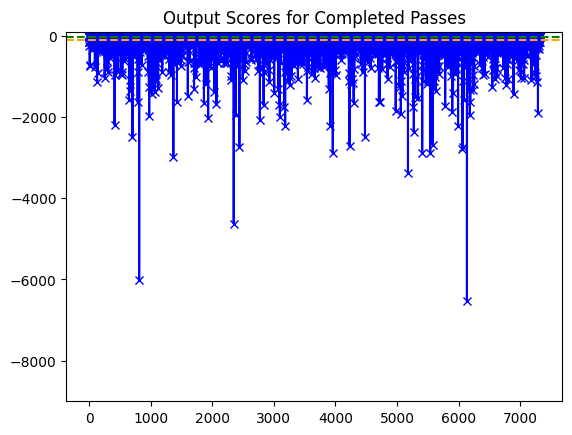

In [25]:
plt.plot(scores[labels=='C'], color='blue', marker='x', linestyle='-')
plt.axhline(y=np.average(scores[labels=='C']), color='orange', linestyle='--', label='Average')
plt.axhline(y=np.median(scores[labels=='C']), color='green', linestyle='--', label='Median')
plt.ylim((-9000, 100))
plt.title('Output Scores for Completed Passes')

print('Average Score: ' + str(np.average(scores[labels=='C'])))
print('Median Score: ' + str(np.median(scores[labels=='C'])))

Average Score: -307.0801143132268
Median Score: -80.00227985267773


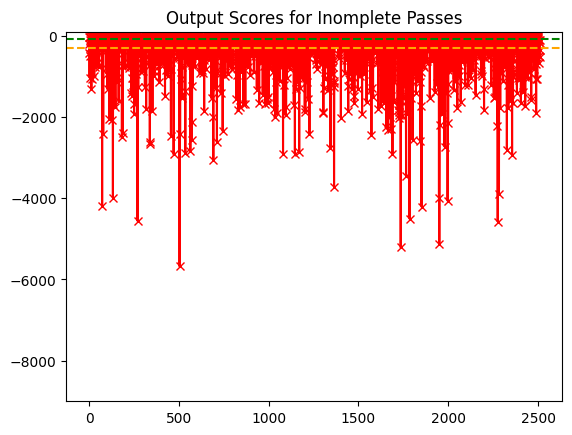

In [26]:
plt.plot(scores[labels=='I'], color='red', marker='x', linestyle='-')
plt.axhline(y=np.average(scores[labels=='I']), color='orange', linestyle='--', label='Average')
plt.axhline(y=np.median(scores[labels=='I']), color='green', linestyle='--', label='Median')
plt.ylim((-9000, 100))
plt.title('Output Scores for Inomplete Passes')

print('Average Score: ' + str(np.average(scores[labels=='I'])))
print('Median Score: ' + str(np.median(scores[labels=='I'])))

In [27]:
full_data.keys()

dict_keys(['2023090700101', '2023090700219', '2023090700361', '2023090700461', '2023090700530', '2023090700713', '2023090700877', '20230907001069', '20230907001154', '20230907001201', '20230907001300', '20230907001494', '20230907001563', '20230907001588', '20230907001618', '20230907001679', '20230907001711', '20230907001812', '20230907001837', '20230907001940', '20230907002118', '20230907002141', '20230907002186', '20230907002306', '20230907002364', '20230907002435', '20230907002487', '20230907002510', '20230907002825', '20230907002906', '20230907002959', '20230907003089', '20230907003114', '20230907003233', '20230907003461', '20230907003486', '20230907003674', '20230907003912', '20230907003971', '20230907004041', '2023091000185', '2023091000661', '2023091000842', '2023091000877', '20230910001046', '20230910001193', '20230910001240', '20230910001300', '20230910001382', '20230910001599', '20230910001697', '20230910001720', '20230910001743', '20230910001837', '20230910001925', '202309100

In [28]:
print(full_data['2023090700219'])

Play(
  target_player_id=53591,
  target_player_name=Noah Gray,
  target_player_name=TE,
  receiver_route=HITCH,
  defensive_coverage=COVER_4_ZONE,
  offense_team=KC,
  defense_team=DET,
  player_movement_input_keys=[44888, 55910, 47888, 44906, 53542, 53953, 54562, 52440, 46243, 46309, 54519, 44822, 53591],
  player_movement_output_keys=[44888, 53953, 53591],
  player_overlay_keys=[44888, 53953, 53591],
  play output num frames=8.0,
  play ball land location=[75.84999847 11.48999977],
  play result=C,
  play score=-19.368916153040367
)


In [29]:
# Create a regular grid to interpolate the data
xi = np.linspace(min(coords_x), max(coords_x), 200)
yi = np.linspace(min(coords_y), max(coords_y), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate using griddata (cubic gives smoother results)
zi = griddata((coords_x, coords_y), probs, (xi, yi), method='cubic')

# Plot the heatmap
plt.figure(figsize=(9, 4))
heatmap = plt.pcolormesh(xi, yi, zi, cmap='viridis', shading='auto')
plt.scatter(coords_x, coords_y, c=probs, cmap='viridis', edgecolors='k', s=30)
plt.colorbar(heatmap, label='Probability')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Probability Heat Map')
plt.show()

NameError: name 'coords_x' is not defined